In [ ]:
!awk -F' ' '{split($3,a,"-");print $1 " " $2 " " a[1];}' /content/test.txt > /content/processed_test.txt
!awk -F' ' '{split($3,a,"-");print $1 " " $2 " " a[1];}' /content/train.txt > /content/processed_train.txt

In [ ]:
import nltk
from nltk.stem.porter import *
from nltk.classify import MaxentClassifier
import pickle
import os,sys
from io import open
change_of_sentence_flag = 0 #a marker for the end of sentence
boi_full_list = [] #store all the boi tags that occur in the training set
boi_end_list = [] #store boi tags that are at the end of the sentence
wordStartList = [] #store words that are begining of the sentence
BOI_list = ['B','O','I']
labeled_features = []

training_file = open("/content/processed_train.txt", "r")
testing_file = open("/content/processed_test.txt", "r")
output_file = open("boi_output.txt", "w")

#****************************************************************building input features part.1
previous_BOI = "start"
previous_tag = 'START'
input_file = training_file
sents = []
sent = []
previous_word = ""
for line in input_file:
	s = re.match(r'^\s*$', line)  #find empty line
	if s:
		change_of_sentence_flag = 1
		previous_BOI = "start"
		previous_tag = 'START'
		previous_word = ""
		sents.append(sent)
		sent = []
	else: 
		sentenceList = line.split()
		word = sentenceList[0]
		tag = sentenceList[1]
		boi = sentenceList[2] 
		sent.append(word)
		#store words that are begining of the sentence
		if change_of_sentence_flag == 1:
			wordStartList.append(word)
			boi_end_list.append(boi_full_list[-1])
			change_of_sentence_flag = 0
		boi_full_list.append(boi)
		item = word, tag, boi, previous_BOI, previous_tag,previous_word
		labeled_features.append(item)
		previous_BOI = boi
		previous_tag = tag
		previous_word = word
        #labeled_features 

#print("labeled_features")
# print(labeled_features)
#unlabeled_features = []

input_file.close()


In [ ]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

model = Word2Vec(sents, min_count=1)
words = list(model.wv.vocab)
model.save('model.bin')
new_model = Word2Vec.load('model.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#****************************************************************calculate End Transition
#calculate the End prior
dicE = {} #temporarry dic 
countTag = 0
countEnd = 0
#calculate the prior (End|state) = C(state, End)/C(state) 
for i in BOI_list:
	for j  in range(len(boi_end_list)):
		for f in boi_full_list:
			if j == 0:
				if i == f:
					countTag = countTag + 1 
		if i == boi_end_list[j]:
			countEnd = countEnd + 1 
	ProbE = format(countEnd/(countTag*1.0), '.5f')
	dicE.update({i: {"END":ProbE}})

	countEnd = 0
	countTag = 0


In [ ]:
lis_noun_suff = ['acy','al','ance','ence','dom','er','or','ism','ist','ity','ty','ment','ness','ship','tion','sion']
lis_verb_suff = ['ate','en','ify','fy','ize','ise','ed','ing','in','ted']
lis_adv_suff = ['ly','ward','wise']
lis_adj_suff = ['able','ible','al','esque','ful','ic','ical','ious','ous','ish','ive','less','y']

stemmer = PorterStemmer() 

def give_morphological_features(word):
    ret = [0]*10
    if word=="":
        return ret
    temp = 0
    temp = ord(word[0])
    temp2 = -5
    temp3 = -5
    if(len(word)>2):
        temp2 = ord(word[-2])
        temp3 = ord(word[-3])
    flag = 0
    flag2 = 0
    verb_flag = 0
    len_flag = 0
    poss_flag = 0
    #Suffix
    bi_suf = word[-2:]
    tri_suf = word[-3:]
    four_suf = word[-4:]
    stem = stemmer.stem(word)
    if((bi_suf in lis_adj_suff or tri_suf in lis_adj_suff or four_suf in lis_adj_suff) and stem!=word):
        ret[5] = 1
    elif((bi_suf in lis_noun_suff or tri_suf in lis_noun_suff or four_suf in lis_noun_suff) and stem!=word):
        ret[6] = 1
    elif((bi_suf in lis_adv_suff or tri_suf in lis_adv_suff or four_suf in lis_adv_suff) and stem!=word):
        ret[7] = 1 
        flag2 = 1
    elif((bi_suf in lis_verb_suff or tri_suf in lis_verb_suff or four_suf in lis_verb_suff) and stem!=word):
        ret[8] = 1
        verb_flag = 1
    #Check Hyphen
    for jj in range(len(word)-1):
        if(ord(word[jj])==45 and ord(word[jj+1])!=45):
            ret[4] = 1 
            flag = 1
            break
    #Check Number
    if(temp<=57 and temp >=47):
        ret[0] = 1
    #Check First Upper Cap 
    if(temp<=90 and temp>=65):
        ret[1] = 1 
    #Check LOwer Cap  
    if(len(word)<=3):
        ret[2] = 1 
        len_flag = 1
    if(temp2==39 or temp3==39): 
      # print(word)
        ret[9] = 1
        poss_flag = 1
    if((temp==46 or temp==96 or temp==95 or temp ==94 or temp==58 or temp ==59 or temp ==33 or temp==34  or temp ==44)):
        ret[3] = 1  
    return ret


#****************************************************************building input features part.2
def MEMM_features(word, tag, previous_BOI, previous_tag,previous_word):
    stemmer = PorterStemmer() 
    features = {} 
    features['current_word'] = word
    features['current_tag'] = tag
    # puc = '-'.decode("utf-8")
        #some char is outof ASCII
    # print (word)
    features['capitalization'] = word[0].isupper()
    features['start_of_sentence'] = word in wordStartList
    features['cap_start'] = word not in wordStartList and word[0].isupper()
    features['pre_capitalization'] = previous_word[0].isupper() if previous_word != "" else False
    features['pre_start_of_sentence'] = previous_word in wordStartList
    features['pre_cap_start'] = previous_word not in wordStartList and previous_word[0].isupper() if previous_word!="" else False
    # features.update(dict(zip(range(200,210),give_morphological_features(word))))
    # features.update(dict(zip(range(210,220),give_morphological_features(previous_word))))
    features['previous_NC'] = previous_BOI
    features['previous_tag'] = previous_tag
    features['previous_word'] = previous_word
    # try:
    #     l1 = new_model[word]
    #     features.update(dict(zip(range(100),l1)))
    # except:
    #     features.update(dict(zip(range(100),[0]*100)))
    # try:
    #     l1 = new_model[previous_word]
    #     features.update(dict(zip(range(100,200),l1)))
    # except:
    #     features.update(dict(zip(range(100,200),[0]*100)))
    return features

In [ ]:
labeled_featuresets = [(MEMM_features(word, tag, previous_BOI, previous_tag,previous_word), boi )for (word, tag, boi, previous_BOI,previous_tag,previous_word) in labeled_features]
train_set = labeled_featuresets

In [ ]:
print(train_set[1])

({'current_word': 'in', 'current_tag': 'IN', 'capitalization': False, 'start_of_sentence': False, 'cap_start': False, 'pre_capitalization': True, 'pre_start_of_sentence': False, 'pre_cap_start': True, 200: 0, 201: 0, 202: 1, 203: 0, 204: 0, 205: 0, 206: 0, 207: 0, 208: 0, 209: 0, 210: 0, 211: 1, 212: 0, 213: 0, 214: 0, 215: 0, 216: 1, 217: 0, 218: 0, 219: 0, 'previous_NC': 'B', 'previous_tag': 'NN', 'previous_word': 'Confidence'}, 'B')


In [ ]:
#*******************************************************************train the model
f = open("my_classifier.pickle", "wb")

maxent_classifier = MaxentClassifier.train(train_set, max_iter=30)
pickle.dump(maxent_classifier , f)

f.close() 

  ==> Training (30 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.132
             2          -0.55412        0.807
             3          -0.39565        0.893
             4          -0.31091        0.922
             5          -0.26065        0.934
             6          -0.22794        0.939
             7          -0.20511        0.942
             8          -0.18830        0.944
             9          -0.17539        0.945
            10          -0.16514        0.947
            11          -0.15679        0.948
            12          -0.14984        0.949
            13          -0.14395        0.951
            14          -0.13887        0.951
            15          -0.13445        0.952
            16          -0.13054        0.953
            17          -0.12707        0.954
            18          -0.12395        0.954
            19          -0.12113        0.955
  

In [ ]:
#********************************************************************Viterbi
def MEMM(wordList,tagList):
    BOI_list =  ['B','O','I']
    w1 = wordList[0] #the first word of the sentence
    t1 = tagList[0]
    tRange = len(BOI_list)
    wRange = len(wordList)

    viterbi = [[0 for x in range(300)] for x in range(300)] 
    backpointer = [['' for x in range(300)] for x in range(300)] 
    #intialization
    for t in range(tRange):#t = 0,1,2
        probability = maxent_classifier.prob_classify(MEMM_features(w1,t1, "start","START","")) 
        posterior = float(probability.prob(BOI_list[t]))
        #print ("boi: " + BOI_list[t] + ' posterior (start)' + str(posterior))
        #score transition 0(start) -> q given w1
        viterbi[t][1] = posterior
        backpointer[t][1] = 0 #stand for q0 (start point)

    #for word w from 2 to T
    maxViterbi = 0
    maxPreviousState = 0 
    maxPreTerminalProb = 0
    prev_tag = t1
    prev_word = ""
    for w in range (1, wRange):	
        word = wordList[w]
        tag = tagList[w]
        for t in range (tRange):
            #find max verterbi = max (previous * posterior)	
            probability = maxent_classifier.prob_classify(MEMM_features(word,tag,BOI_list[0],prev_tag,prev_word)) 
            posterior = float(probability.prob(BOI_list[t]))
            maxViterbi = float(viterbi[0][w]) * posterior
            maxPreviousState = 0
            for i in range (1, tRange):
                probability = maxent_classifier.prob_classify(MEMM_features(word,tag,BOI_list[i],prev_tag,prev_word)) 
                posterior = float(probability.prob(BOI_list[t]))
                if float(viterbi[i][w]) * posterior > maxViterbi:
                        maxViterbi = float(viterbi[i][w]) * posterior
                        maxPreviousState = i #content BOI_List[i]		
            viterbi[t][w+1] = maxViterbi	
            backpointer[t][w+1] = BOI_list[maxPreviousState] #points to the matrix x axis (max previous)
            
            maxViterbi = 0
            maxPreviousState = 0 
            maxPreTerminalProb = 0
        prev_tag = tag
        prev_word = word
	#termination step
	#viterbi[qF, T] = max (viterbi[s,T] *as,qF)
    maxPreTerminalProb = float(viterbi[0][wRange] )* float(dicE[BOI_list[0]]["END"])

    maxPreviousState = 0
    for i in range (1, tRange):
		
        if float(viterbi[i][wRange]) * float(dicE[BOI_list[i]]["END"]) > maxPreTerminalProb:
            maxPreTerminalProb = float(viterbi[i][wRange]) * float(dicE[BOI_list[i]]["END"]) 

            maxPreviousState = i

            #print ("maxPreTerminalProb: " + str(maxPreTerminalProb))
    viterbi[tRange][wRange+1] = maxPreTerminalProb 
    backpointer[tRange][wRange+1] = BOI_list[maxPreviousState]
    #return POS tag path 
    pathReverse = [BOI_list[maxPreviousState]]
    maxPreviousTag = BOI_list[maxPreviousState]
	
    i = 0
    while i < (wRange -1):
        pathReverse.append(backpointer[BOI_list.index(maxPreviousTag)][wRange - i])
        maxPreviousTag = backpointer[BOI_list.index(maxPreviousTag)][wRange - i]
        i = i + 1 

    #reverse the path to make it correct
    index = len(pathReverse)
    path = []
    while index >= 1 :
        path.append(pathReverse[index - 1])
        index = index -1 
    return path



In [ ]:
testing_file = open("/content/processed_test.txt", "r")
output_file = open("boi_output.txt", "w")

In [ ]:
#*******************************************************************MaxEnt+Viterbi = MEMM
#main()
wordList = [] #store words in a sentence
tagList = [] #store part-of-speech tag in a sentence 
boiList = [] #store boi tags in a sentence 
#prob_table = {} #stpre the posterior
previous_BOI = "start"
previous_tag = 'START'
BOI_list =  ['B','O','I']

input_file = testing_file
for line in input_file:
	
    if line.strip() != '': #if not empty do following 
        sentenceList = line.split()
        word = sentenceList[0]
        # print (word)
        tag = sentenceList[1]
        boi = sentenceList[2]
        wordList.append(word)
        tagList.append(tag)
        boiList.append(boi)
        #store words that are begining of the sentence
        #store tags that are the begining of the sentence
        #store the end of sentence tag in tagEndList
        if change_of_sentence_flag == 1:
            wordStartList.append(word)
            change_of_sentence_flag = 0
    s = re.match(r'^\s*$', line)  #find empty line
    if s:
        #print (wordList)
        change_of_sentence_flag = 1
        previous_BOI = "start"
        previous_tag = 'START'
        path = MEMM(wordList, tagList) #list of BOI_tags returned by HMM function call

        for i in range(len(wordList)): #part_of_speech_tag(tagList) and token_list(wordList) has the same length
            output_file.write(wordList[i]+"	"+ tagList[i]+ " " + boiList[i] + " " + path[i] + "\n")

        output_file.write("\n")
        wordList = [] # refresh word list
        tagList = []
        boiList = []
        #prob_table = {}#refresh prob_table

input_file.close()
output_file.close()

In [ ]:
import numpy as np
cm = np.zeros((3,3))
with open("/content/boi_output.txt",'r') as f:
    a1 = f.readlines()
    for line in a1:
        if line.rstrip()=="":
            continue
        else:
            x = line.rstrip().split(" ")
            if x[1] == 'B':
                if x[2] == 'B':
                    cm[0][0] += 1
                elif x[2]=='I' :
                    cm[0][1] += 1
                elif x[2] == 'O':
                    cm[0][2] += 1
            elif x[1] == 'I':
                if x[2] == 'B':
                    cm[1][0] += 1
                elif x[2]=='I' :
                    cm[1][1] += 1
                elif x[2] == 'O':
                    cm[1][2] += 1
            elif x[1] == 'O':
                if x[2] == 'B':
                    cm[2][0] += 1
                elif x[2]=='I' :
                    cm[2][1] += 1
                elif x[2] == 'O':
                    cm[2][2] += 1

In [ ]:
cm

array([[22617.,  1165.,    70.],
       [ 1078., 15894.,   373.],
       [  108.,   151.,  5921.]])

In [ ]:
print(f'Precision for B tag {cm[0][0]*1.0/(cm[0][0]+cm[1][0]+cm[2][0])}')
print(f'Precision for I tag {cm[1][1]*1.0/(cm[0][1]+cm[1][1]+cm[2][1])}')
print(f'Precision for O tag {cm[2][2]*1.0/(cm[0][2]+cm[1][2]+cm[2][2])}')

print(f'Recall for B tag {cm[0][0]*1.0/(cm[0][0]+cm[0][1]+cm[0][2])}')
print(f'Recall for I tag {cm[1][1]*1.0/(cm[1][0]+cm[1][1]+cm[1][2])}')
print(f'Recall for O tag {cm[2][2]*1.0/(cm[2][0]+cm[2][1]+cm[2][2])}')

Precision for B tag 0.9501743477712893
Precision for I tag 0.9235328297501453
Precision for O tag 0.930389692017599
Recall for B tag 0.9482223712896193
Recall for I tag 0.9163447679446526
Recall for O tag 0.9580906148867314


per_pos [0.94822237 0.91634477 0.95809061]


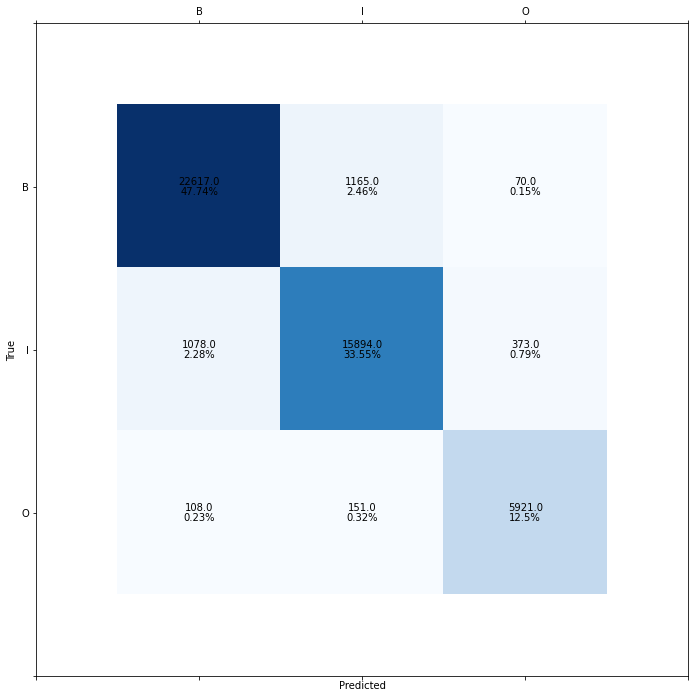

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn
import itertools
# from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(12,12))
# Acc = np.zeros((5))
# for i in range(5):
#   for j in range(len(test_lab[i])):
#     if(test_lab[i][j]==fin_pred[i][j]):
#       Acc[i] = Acc[i]+1
#   Acc[i] = Acc[i]/len(test_lab[i])
# print("5 fold Acc",Acc) 
# print("Avg Accuracy",np.sum(Acc)/5)     
# test_y_true = np.array(list(itertools.chain.from_iterable(test_y_true)))
labels=['B','I','O']
ax.matshow(cm, cmap=plt.cm.Blues)
lis = [-1,0,1,2,3]
ax.set_xticks(lis)
ax.set_yticks(lis)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
for i in range(3):
  for j in range(3):
    c = cm[j,i]
    ax.text(i, j, str(c), va='bottom', ha='center')
    ax.text(i,j,str(round((c/cm.sum()*100),2))+"%",va='top', ha='center')
plt.xlabel('Predicted')
plt.ylabel('True')
per_Pos = np.zeros((3))    
for i in range(3):
  per_Pos[i] = cm[i][i]/np.sum(cm[i])
print("per_pos",per_Pos)   
plt.savefig('memm_cm')

In [ ]:
true_pos = np.diag(cm)
false_pos = np.sum(cm, axis=0) - true_pos
false_neg = np.sum(cm, axis=1) - true_pos
print(true_pos)
print(false_pos)
print(false_neg)
prec_b=true_pos[0]/(true_pos[0]+false_pos[0])
rec_b=true_pos[0]/(true_pos[0]+false_neg[0])
f1_b=2*prec_b*rec_b/(rec_b+prec_b)
print("Precision for B=",prec_b,"and recall for B=",rec_b,"and f1 score=",f1_b)

prec_i=true_pos[1]/(true_pos[1]+false_pos[1])
rec_i=true_pos[1]/(true_pos[1]+false_neg[1])
f1_i=2*prec_i*rec_i/(rec_i+prec_i)
print("Precision for I=",prec_i,"and recall for I=",rec_i,"and f1 score=",f1_i)

prec_O=true_pos[2]/(true_pos[2]+false_pos[2])
rec_O=true_pos[2]/(true_pos[2]+false_neg[2])
f1_O=2*prec_O*rec_O/(rec_O+prec_O)
print("Precision for O=",prec_O,"and recall for O=",rec_O,"and f1 score=",f1_O)

overall_prec=np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_pos))
overall_rec=np.sum(true_pos)/(np.sum(true_pos)+np.sum(false_neg))
overall_f1=2*overall_prec*overall_rec/(overall_rec+overall_prec)
print("Overall precision:",overall_prec,"Overall recall:",overall_rec,"Overall f1 score:",overall_f1)

[22617. 15894.  5921.]
[1186. 1316.  443.]
[1235. 1451.  259.]
Precision for B= 0.9501743477712893 and recall for B= 0.9482223712896193 and f1 score= 0.9491973559962228
Precision for I= 0.9235328297501453 and recall for I= 0.9163447679446526 and f1 score= 0.9199247576327594
Precision for O= 0.930389692017599 and recall for O= 0.9580906148867314 and f1 score= 0.9440369897959184
Overall precision: 0.9378390358190684 Overall recall: 0.9378390358190684 Overall f1 score: 0.9378390358190685


In [ ]:
print((cm[0][0]+cm[1][1]+cm[2][2])/(np.sum(cm)))

0.9378390358190684
